In [ ]:
# 1. Setup & Imports 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import optuna
from optuna.integration import LightGBMPruningCallback
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
import shap


# Advanced Model
import lightgbm as lgb

import os

import warnings
warnings.filterwarnings('ignore', message='.*dask-expr.*')

In [3]:
# 2. Load Latest Preprocessed Data 

# Find the most recent preprocessed data folder
preprocessed_dir = os.path.join('../..', 'data', 'preprocessed')
latest_folder = sorted([d for d in os.listdir(preprocessed_dir) if os.path.isdir(os.path.join(preprocessed_dir, d))])[-1]
latest_data_path = os.path.join(preprocessed_dir, latest_folder)
print(f"Loading data from the most recent folder: '{latest_data_path}'")

# Load the scaled data sets
X_train = pd.read_csv(os.path.join(latest_data_path, 'X_train_scaled.csv'))
y_train = pd.read_csv(os.path.join(latest_data_path, 'y_train_scaled.csv')).squeeze()
X_test = pd.read_csv(os.path.join(latest_data_path, 'X_test_scaled.csv'))
y_test = pd.read_csv(os.path.join(latest_data_path, 'y_test_scaled.csv')).squeeze()

print(f"\nData loaded successfully. Training with {len(X_train)} samples.")



Loading data from the most recent folder: '../../data/preprocessed/preprocessed_data_20250720_131842'

Data loaded successfully. Training with 1688 samples.


In [ ]:
print("\n\n--- Training Advanced Model: LightGBM Classifier ---")

lgbm_model = lgb.LGBMClassifier(verbosity=-1, 
                                random_state=42, 
                                gpu_device_id=0,
                                gpu_platform_id=0)

param_grid_lgbm = {
    'n_estimators': [300, 350, 400, 450, 500],
    'learning_rate': [0.025, 0.05, 0.075],
    'num_leaves': [20, 30, 40, 50],
    'max_depth': [6, 7, 8, 9],
    'min_child_samples': [10, 20, 30],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0.0, 0.1],
    'reg_lambda': [0.0, 0.1],
    'boosting_type': ['gbdt'],
    'objective': ['multiclass'],
    'num_class': [7]  # Assuming a 7-class classification problem
}

# Use GridSearchCV with 'accuracy' as the scoring metric
grid_lgbm = GridSearchCV(lgbm_model, param_grid_lgbm, cv=5, scoring='accuracy', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

# Print the best parameters and score
print(f"\nBest parameters for LightGBM: {grid_lgbm.best_params_}")
print(f"Best cross-validated Accuracy: {grid_lgbm.best_score_:.4f}")

# Evaluate on the test set
y_pred_lgbm = grid_lgbm.predict(X_test)
train_accuracy_lgbm = accuracy_score(y_train, grid_lgbm.predict(X_train))
test_accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

print(f"\nLightGBM Train Accuracy: {train_accuracy_lgbm:.4f}")
print(f"LightGBM Test Accuracy: {test_accuracy_lgbm:.4f}")

print("\nLightGBM Test Set Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Confusion Matrix
cm = confusion_matrix(y_test.values, y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i}' for i in range(len(cm))],
            yticklabels=[f'Class {i}' for i in range(len(cm))])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
def objective(trial):
    """Optuna objective function for LightGBM"""
    
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, 5),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.1, 0.01),
        'num_leaves': trial.suggest_int('num_leaves', 10, 100, 5),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100, 5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, 0.01),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, 0.01),
        'reg_alpha': [0.0],
        'reg_lambda': [0.0],
        'verbosity': -1,
        'random_state': 42,
        'gpu_device_id': 0,
        'gpu_platform_id': 0,
        'objective': 'multiclass',
        'num_class': 7
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx] 
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Create model with pruning callback
        model = lgb.LGBMClassifier(**params)
        
        # Fit with early stopping and pruning
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)]
        )
        
        # Get validation score
        val_pred = model.predict(X_val)
        val_score = accuracy_score(y_val, val_pred)
        scores.append(val_score)
    
    return np.mean(scores)

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2000)  # Much faster than GridSearch

print(f"Best parameters: {study.best_params}")
print(f"Best accuracy: {study.best_value:.4f}")

In [4]:
def evaluate_top_models(study, X_train, y_train, X_test, y_test, top_n=5):
    """Train and evaluate top N models on test set"""
    
    trials = sorted(study.trials, key=lambda t: t.value, reverse=True)
    top_trials = trials[:top_n]
    
    results = []
    
    print(f"\n🧪 EVALUATING TOP {top_n} MODELS ON TEST SET:")
    print("="*80)
    
    for rank, trial in enumerate(top_trials, 1):
        # Get parameters
        params = trial.params.copy()
        params.update({
            'verbosity': -1,
            'random_state': 42,
            'objective': 'multiclass',
            'num_class': 7,
            'gpu_device_id': 0,
            'gpu_platform_id': 0,
        })
        
        # Train model
        model = lgb.LGBMClassifier(**params)
        model.fit(X_train, y_train)
        
        # Evaluate
        train_pred = model.predict(X_train)
        test_pred = model.predict(X_test)
        
        train_acc = accuracy_score(y_train, train_pred)
        test_acc = accuracy_score(y_test, test_pred)
        
        print(f"\n#{rank} - CV: {trial.value:.4f} | Train: {train_acc:.4f} | Test: {test_acc:.4f}")
        print(f"   Key params: {params}")
        
        results.append({
            'Rank': rank,
            'CV_Accuracy': trial.value,
            'Train_Accuracy': train_acc,
            'Test_Accuracy': test_acc,
            'Params': params
        })
    
    return results

# Evaluate top models
top_results = evaluate_top_models(study, X_train, y_train, X_test, y_test, top_n=200)

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Rank': r['Rank'],
        'CV_Accuracy': r['CV_Accuracy'],
        'Train_Accuracy': r['Train_Accuracy'], 
        'Test_Accuracy': r['Test_Accuracy'],
        'Overfitting': r['Train_Accuracy'] - r['Test_Accuracy']
    }
    for r in top_results
])

print("\n📈 MODEL COMPARISON:")
display(comparison_df.round(4))

NameError: name 'study' is not defined


Best parameters for LightGBM: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8785984716278369, 'learning_rate': 0.18502652149436183, 'max_depth': 5, 'min_child_samples': 45, 'n_estimators': 815, 'num_class': 7, 'num_leaves': 70, 'objective': 'multiclass', 'reg_alpha': 0.00011286229652520546, 'reg_lambda': 0.01701653807848482, 'subsample': 0.6633868530528707}
Best cross-validated Accuracy: 0.9686

LightGBM Train Accuracy: 1.0000
LightGBM Test Accuracy: 0.9740

LightGBM Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        54
           1       0.89      0.97      0.93        58
           2       1.00      0.99      0.99        70
           3       0.98      1.00      0.99        60
           4       1.00      0.98      0.99        65
           5       0.96      0.93      0.95        58
           6       1.00      1.00      1.00        58

    accuracy                           0.97       423
   ma

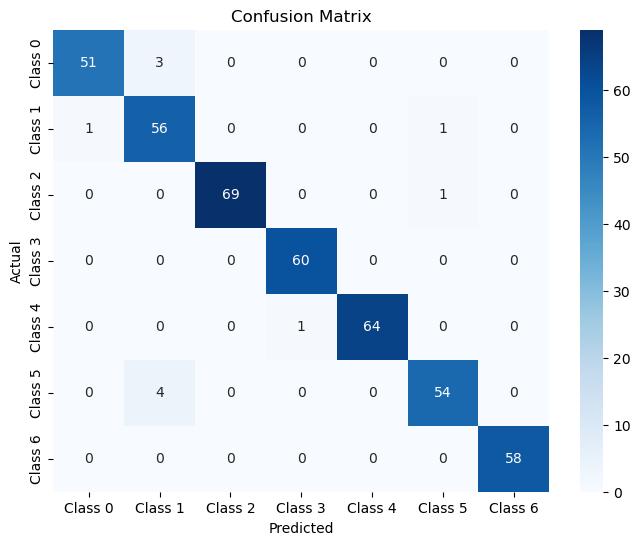

In [5]:
lgbm_model = lgb.LGBMClassifier(verbosity=-1, 
                                random_state=42, 
                                gpu_device_id=0,
                                gpu_platform_id=0)

param_grid_lgbm = {
    'n_estimators': [815],
    'learning_rate': [0.18502652149436183],
    'num_leaves': [70],
    'max_depth': [5],
    'min_child_samples': [45],
    'subsample': [0.6633868530528707],
    'colsample_bytree': [0.8785984716278369],
    'reg_alpha': [0.00011286229652520546],
    'reg_lambda': [0.01701653807848482],
    'boosting_type': ['gbdt'],
    'objective': ['multiclass'],
    'num_class': [7]  # Assuming a 7-class classification problem
}

# Use GridSearchCV with 'accuracy' as the scoring metric
grid_lgbm = GridSearchCV(lgbm_model, param_grid_lgbm, cv=5, scoring='accuracy', n_jobs=-1)
grid_lgbm.fit(X_train, y_train)

# Print the best parameters and score
print(f"\nBest parameters for LightGBM: {grid_lgbm.best_params_}")
print(f"Best cross-validated Accuracy: {grid_lgbm.best_score_:.4f}")

# Evaluate on the test set
y_pred_lgbm = grid_lgbm.predict(X_test)
train_accuracy_lgbm = accuracy_score(y_train, grid_lgbm.predict(X_train))
test_accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

print(f"\nLightGBM Train Accuracy: {train_accuracy_lgbm:.4f}")
print(f"LightGBM Test Accuracy: {test_accuracy_lgbm:.4f}")

print("\nLightGBM Test Set Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Confusion Matrix
cm = confusion_matrix(y_test.values, y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i}' for i in range(len(cm))],
            yticklabels=[f'Class {i}' for i in range(len(cm))])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

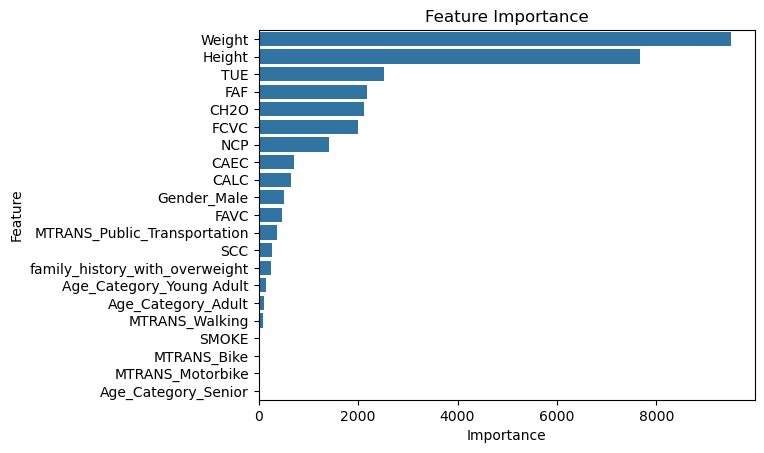

In [6]:
best_model_lgb = grid_lgbm.best_estimator_

# Get feature importance
feature_importance = best_model_lgb.feature_importances_

# Get feature names
feature_names = X_train.columns.tolist()

# Create DataFrame 
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

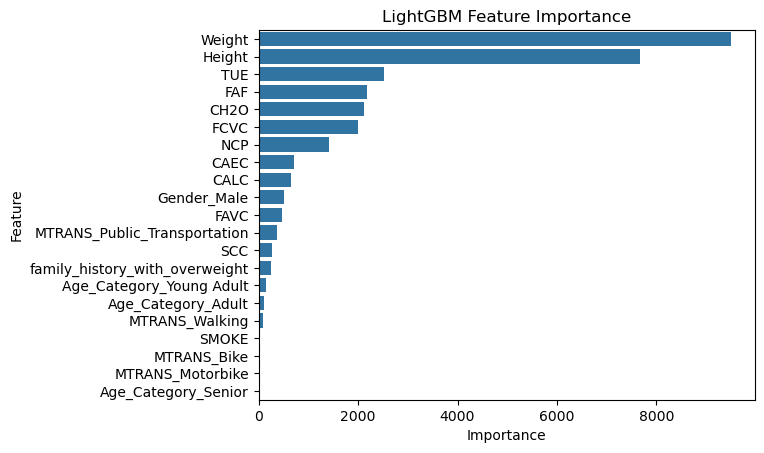

In [7]:
# Get feature importance
feature_importance = grid_lgbm.best_estimator_.feature_importances_

# Get feature names
feature_names = X_train.columns.tolist()

# Create DataFrame 
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('LightGBM Feature Importance')
plt.show()

In [24]:
# Initialize SHAP explainer with your best model
best_model_lgb = grid_lgbm.best_estimator_

# Create SHAP explainer for tree-based models
explainer = shap.TreeExplainer(best_model_lgb)

# Calculate SHAP values for test set (or subset for speed)
# Use a sample if your dataset is large
sample_size = min(1000, len(X_test))  # Use max 1000 samples for visualization
X_test_sample = X_test.sample(n=sample_size, random_state=42)

print(f"Calculating SHAP values for {len(X_test_sample)} samples...")
shap_values = explainer.shap_values(X_test_sample)

print("SHAP values calculated successfully!")
print(f"SHAP values shape: {len(shap_values)} classes x {shap_values[0].shape}")

Calculating SHAP values for 423 samples...
SHAP values calculated successfully!
SHAP values shape: 423 classes x (21, 7)


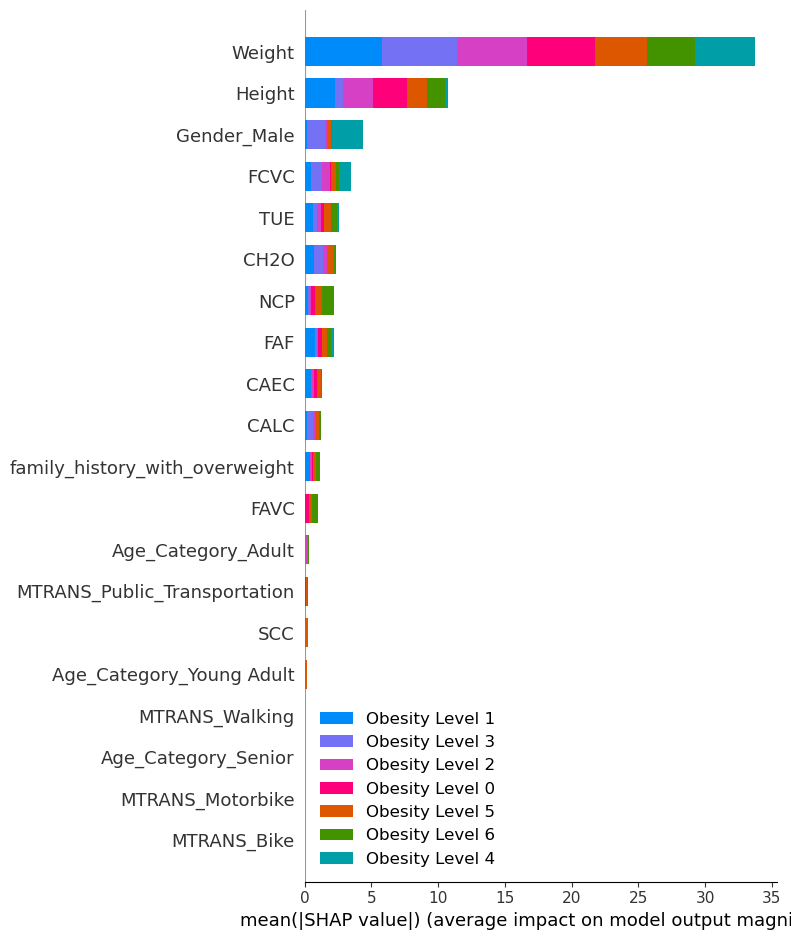

In [30]:
# 1. Overall feature importance across all classes
shap.summary_plot(shap_values, X_test_sample, plot_type="bar", 
                 class_names=[f'Obesity Level {i}' for i in range(7)])

SHAP values shape: (423, 21, 7)
Shape interpretation: (423 samples, 21 features, 7 classes)

Sample 0 prediction: Class 3
Class probabilities: [1.04792487e-10 9.45355491e-13 1.52379576e-06 9.99998458e-01
 7.91163818e-09 2.69333824e-10 9.70378847e-09]


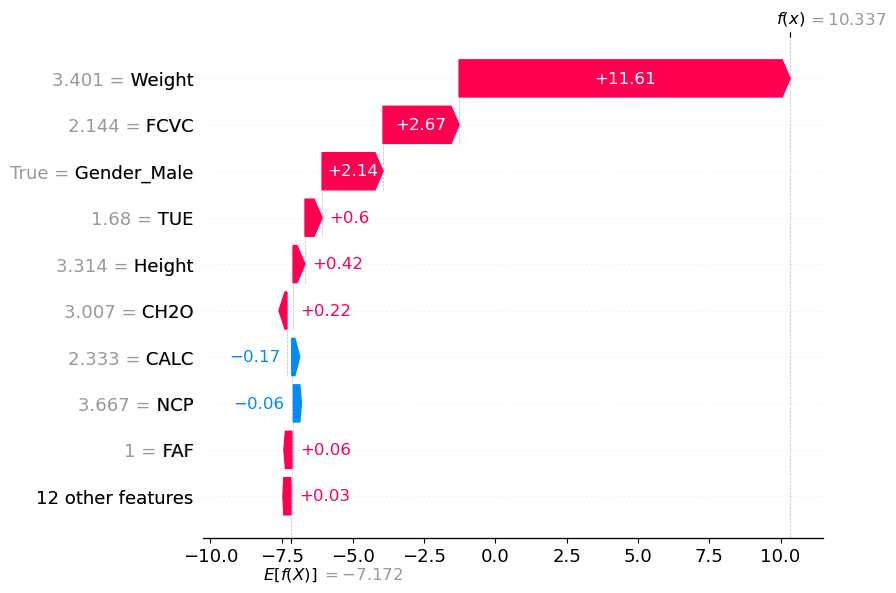

In [49]:
model = grid_lgbm.best_estimator_

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_test_sample)

print(f"SHAP values shape: {shap_values.shape}")
print(f"Shape interpretation: ({shap_values.shape[0]} samples, {shap_values.shape[1]} features, {shap_values.shape[2]} classes)")

sample_id = 0

# Get the predicted class for the first sample to make it meaningful
sample_0_data = X_test_sample.iloc[[sample_id]]
predicted_class = model.predict(sample_0_data)[sample_id]
prediction_proba = model.predict_proba(sample_0_data)[sample_id]

print(f"\nSample 0 prediction: Class {predicted_class}")
print(f"Class probabilities: {prediction_proba}")

# visualize the first prediction's explanation for the predicted class
shap.plots.waterfall(shap_values[0, :, predicted_class])

In [54]:
selected_columns = ['Weight', 
                    'Height', 
                    'Gender_Male', 
                    'FCVC',
                    'TUE',
                    'CH2O',
                    'NCP',
                    'FAF',
                    'CAEC',
                    'CALC',
                    'family_history_with_overweight',
                    'FAVC']
X_train_selected = X_train[selected_columns].copy()
X_test_selected = X_test[selected_columns].copy()



Best parameters for LightGBM: {'boosting_type': 'gbdt', 'colsample_bytree': 0.8785984716278369, 'learning_rate': 0.18502652149436183, 'max_depth': 5, 'min_child_samples': 45, 'n_estimators': 815, 'num_class': 7, 'num_leaves': 70, 'objective': 'multiclass', 'reg_alpha': 0.00011286229652520546, 'reg_lambda': 0.01701653807848482, 'subsample': 0.6633868530528707}
Best cross-validated Accuracy: 0.9674

LightGBM Train Accuracy: 1.0000
LightGBM Test Accuracy: 0.9645

LightGBM Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.94      0.96        54
           1       0.86      0.97      0.91        58
           2       1.00      0.97      0.99        70
           3       0.98      1.00      0.99        60
           4       1.00      0.98      0.99        65
           5       0.96      0.88      0.92        58
           6       0.97      1.00      0.98        58

    accuracy                           0.96       423
   ma

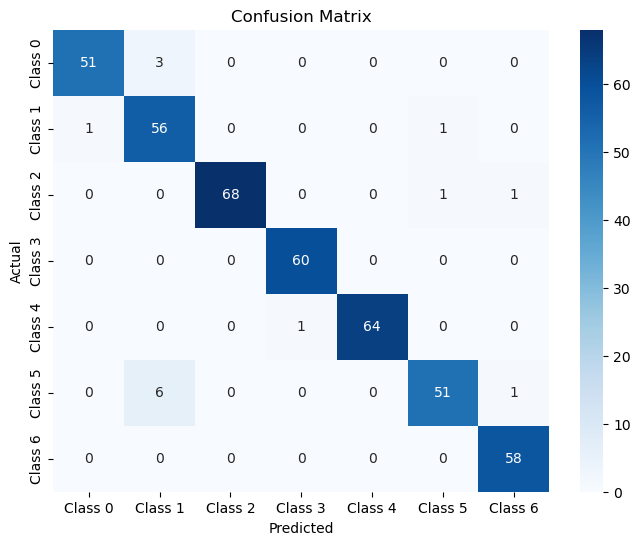

In [56]:
lgbm_model = lgb.LGBMClassifier(verbosity=-1, 
                                random_state=42, 
                                gpu_device_id=0,
                                gpu_platform_id=0)

param_grid_lgbm = {
    'n_estimators': [815],
    'learning_rate': [0.18502652149436183],
    'num_leaves': [70],
    'max_depth': [5],
    'min_child_samples': [45],
    'subsample': [0.6633868530528707],
    'colsample_bytree': [0.8785984716278369],
    'reg_alpha': [0.00011286229652520546],
    'reg_lambda': [0.01701653807848482],
    'boosting_type': ['gbdt'],
    'objective': ['multiclass'],
    'num_class': [7]  # Assuming a 7-class classification problem
}

# Use GridSearchCV with 'accuracy' as the scoring metric
grid_lgbm = GridSearchCV(lgbm_model, param_grid_lgbm, cv=5, scoring='accuracy', n_jobs=-1)
grid_lgbm.fit(X_train_selected, y_train)

# Print the best parameters and score
print(f"\nBest parameters for LightGBM: {grid_lgbm.best_params_}")
print(f"Best cross-validated Accuracy: {grid_lgbm.best_score_:.4f}")

# Evaluate on the test set
y_pred_lgbm = grid_lgbm.predict(X_test_selected)
train_accuracy_lgbm = accuracy_score(y_train, grid_lgbm.predict(X_train_selected))
test_accuracy_lgbm = accuracy_score(y_test, y_pred_lgbm)

print(f"\nLightGBM Train Accuracy: {train_accuracy_lgbm:.4f}")
print(f"LightGBM Test Accuracy: {test_accuracy_lgbm:.4f}")

print("\nLightGBM Test Set Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Confusion Matrix
cm = confusion_matrix(y_test.values, y_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[f'Class {i}' for i in range(len(cm))],
            yticklabels=[f'Class {i}' for i in range(len(cm))])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [227]:
def objective2(trial):
    """Optuna objective function for LightGBM"""
    
    # Suggest hyperparameters
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 170, 170, step=1),
        'learning_rate': trial.suggest_float('learning_rate', 0.079, 0.079, step=0.001),
        'num_leaves': trial.suggest_int('num_leaves', 5, 5, step=1),
        'max_depth': trial.suggest_int('max_depth', 6, 6, step=1),
        'min_child_samples': trial.suggest_int('min_child_samples', 255, 255, step=1),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.36, 0.5, step=0.005),
        # 'reg_lambda': trial.suggest_float('reg_lambda', 0, 0.05, step=0.005),
        'subsample': trial.suggest_float('subsample', 0.65, 0.85, step=0.01),
        # 'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.9, step=0.01),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 1),
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt']),
        'verbosity': -1,
        'random_state': 42,
        'gpu_device_id': 0,
        'gpu_platform_id': 0,
        'objective': 'multiclass',
        'num_class': 7
    }
    
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in cv.split(X_train_selected, y_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx] 
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Create model with pruning callback
        model = lgb.LGBMClassifier(**params)
        
        # Fit with early stopping and pruning
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)]
        )
        
        # Get validation score
        val_pred = model.predict(X_val)
        val_score = accuracy_score(y_val, val_pred)
        scores.append(val_score)
    
    return np.mean(scores)

# Create study and optimize
study = optuna.create_study(direction='maximize')
study.optimize(objective2, n_trials=200)  # Much faster than GridSearch

print(f"Best parameters: {study.best_params}")
print(f"Best accuracy: {study.best_value:.4f}")

[I 2025-07-24 00:20:14,234] A new study created in memory with name: no-name-2b5c1da9-b7e4-4ce4-a560-11d82f1948d7
[I 2025-07-24 00:20:14,630] Trial 0 finished with value: 0.8992888873281478 and parameters: {'n_estimators': 170, 'learning_rate': 0.079, 'num_leaves': 5, 'max_depth': 6, 'min_child_samples': 255, 'reg_alpha': 0.49, 'subsample': 0.68, 'subsample_freq': 1, 'boosting_type': 'gbdt'}. Best is trial 0 with value: 0.8992888873281478.
[I 2025-07-24 00:20:15,020] Trial 1 finished with value: 0.9105437817147474 and parameters: {'n_estimators': 170, 'learning_rate': 0.079, 'num_leaves': 5, 'max_depth': 6, 'min_child_samples': 255, 'reg_alpha': 0.47, 'subsample': 0.73, 'subsample_freq': 1, 'boosting_type': 'gbdt'}. Best is trial 1 with value: 0.9105437817147474.
[I 2025-07-24 00:20:15,393] Trial 2 finished with value: 0.9058065422365809 and parameters: {'n_estimators': 170, 'learning_rate': 0.079, 'num_leaves': 5, 'max_depth': 6, 'min_child_samples': 255, 'reg_alpha': 0.5, 'subsample'

Best parameters: {'n_estimators': 170, 'learning_rate': 0.079, 'num_leaves': 5, 'max_depth': 6, 'min_child_samples': 255, 'reg_alpha': 0.38, 'subsample': 0.85, 'subsample_freq': 1, 'boosting_type': 'gbdt'}
Best accuracy: 0.9360


In [228]:
# Evaluate top models
top_results = evaluate_top_models(study, X_train_selected, y_train, X_test_selected, y_test, top_n=500)

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Rank': r['Rank'],
        'CV_Accuracy': r['CV_Accuracy'],
        'Train_Accuracy': r['Train_Accuracy'], 
        'Test_Accuracy': r['Test_Accuracy'],
        'Overfitting': r['Train_Accuracy'] - r['Test_Accuracy']
    }
    for r in top_results
])


🧪 EVALUATING TOP 500 MODELS ON TEST SET:

#1 - CV: 0.9360 | Train: 0.9899 | Test: 0.9433
   Key params: {'n_estimators': 170, 'learning_rate': 0.079, 'num_leaves': 5, 'max_depth': 6, 'min_child_samples': 255, 'reg_alpha': 0.38, 'subsample': 0.85, 'subsample_freq': 1, 'boosting_type': 'gbdt', 'verbosity': -1, 'random_state': 42, 'objective': 'multiclass', 'num_class': 7, 'gpu_device_id': 0, 'gpu_platform_id': 0}

#2 - CV: 0.9360 | Train: 0.9899 | Test: 0.9433
   Key params: {'n_estimators': 170, 'learning_rate': 0.079, 'num_leaves': 5, 'max_depth': 6, 'min_child_samples': 255, 'reg_alpha': 0.38, 'subsample': 0.85, 'subsample_freq': 1, 'boosting_type': 'gbdt', 'verbosity': -1, 'random_state': 42, 'objective': 'multiclass', 'num_class': 7, 'gpu_device_id': 0, 'gpu_platform_id': 0}

#3 - CV: 0.9354 | Train: 0.9887 | Test: 0.9456
   Key params: {'n_estimators': 170, 'learning_rate': 0.079, 'num_leaves': 5, 'max_depth': 6, 'min_child_samples': 255, 'reg_alpha': 0.36, 'subsample': 0.85, 'sub

In [233]:
comparison_df_sorted = comparison_df[comparison_df['Train_Accuracy'] != 1.0].copy()
comparison_df_sorted = comparison_df_sorted[comparison_df_sorted['Test_Accuracy'] >= 0.93].copy()
comparison_df_sorted = comparison_df_sorted[comparison_df_sorted['Overfitting'] < 0.05].copy()
comparison_df_sorted = comparison_df_sorted.sort_values(['Overfitting', 'Test_Accuracy'], 
                                                       ascending=[True, False])

print("\n📈 MODEL COMPARISON:")
display(comparison_df_sorted.round(4))


📈 MODEL COMPARISON:


,Rank,CV_Accuracy,Train_Accuracy,Test_Accuracy,Overfitting
196,197,0.8987,0.9692,0.9385,0.0307
194,195,0.9023,0.9716,0.9409,0.0307
192,193,0.9070,0.9739,0.9433,0.0307
191,192,0.9082,0.9763,0.9456,0.0307
193,194,0.9058,0.9751,0.9433,0.0319
...,...,...,...,...,...
46,47,0.9354,0.9905,0.9409,0.0496
47,48,0.9354,0.9905,0.9409,0.0496
48,49,0.9354,0.9905,0.9409,0.0496
49,50,0.9354,0.9905,0.9409,0.0496
